<a href="https://colab.research.google.com/github/wallacelw/Price-Forecasting-With-LSTM/blob/main/Prices_Forecasting_with_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Datasets available @

BTC, AAPL, MSFT, TSLA, ^IXIC(NASDAQ), ^BVSP(IBOVESPA):
https://finance.yahoo.com/

S&P 500:
https://www.kaggle.com/datasets/andrewmvd/sp-500-stocks?select=sp500_index.csv

## Load Dataset and Preprocess It:

In [20]:
import pandas as pd
import datetime

def str_to_datetime(s):
  year, month, day = [int(i) for i in s.split('-')]
  return datetime.datetime(year=year, month=month, day=day)

price_dict = {
    "Adj Close" : "Price",
    "S&P500" : "Price"
}

def load_df(filename):
  df = pd.read_csv(filename)
  df.rename(columns = price_dict, inplace = True)
  df = df[["Date", "Price"]]

  # Convert date type objects to datetime object
  df["Date"] = df["Date"].apply(str_to_datetime)

  # Turn Date into dataframe index
  df.index = df.pop("Date")

  return df

df = load_df("MSFT.csv")

df

,Price
Date,
1986-03-13,0.060396
1986-03-14,0.062553
1986-03-17,0.063632
1986-03-18,0.062014
1986-03-19,0.060936
...,...
2023-11-01,346.070007
2023-11-02,348.320007
2023-11-03,352.799988


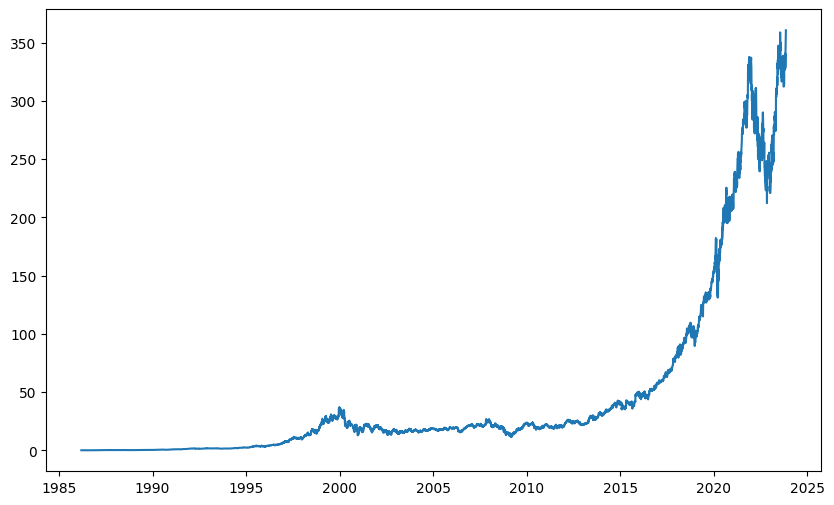

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(df.index, df["Price"])

In [22]:
# Choose the amount of days to consider from the dataset
days = 2000

# numbers of days to consider in the input of the model
lookback = 7 # a single week


def df_to_windowed(df, n=lookback):
  data = pd.DataFrame()
  for i in range(n, 0, -1):
    data[f"Last-{i} Price"] = df["Price"].shift(periods=i)
  data["Price"] = df["Price"]
  return data.dropna()

# Convert to a windowed Dataframe,
# so the last day prices (input) can predict the next day price (output)
windowed_df = df_to_windowed(df)

# Select the amount of data
windowed_df = windowed_df[-days:]

windowed_df

,Last-7 Price,Last-6 Price,Last-5 Price,Last-4 Price,Last-3 Price,Last-2 Price,Last-1 Price,Price
Date,,,,,,,,
2015-11-27,47.168167,47.951786,48.031929,48.254543,48.254543,48.307976,47.809322,48.023026
2015-11-30,47.951786,48.031929,48.254543,48.254543,48.307976,47.809322,48.023026,48.397011
2015-12-01,48.031929,48.254543,48.254543,48.307976,47.809322,48.023026,48.397011,49.171726
2015-12-02,48.254543,48.254543,48.307976,47.809322,48.023026,48.397011,49.171726,49.162815
2015-12-03,48.254543,48.307976,47.809322,48.023026,48.397011,49.171726,49.162815,48.263447
...,...,...,...,...,...,...,...,...
2023-11-01,329.320007,330.529999,340.670013,327.890015,329.809998,337.309998,338.109985,346.070007
2023-11-02,330.529999,340.670013,327.890015,329.809998,337.309998,338.109985,346.070007,348.320007
2023-11-03,340.670013,327.890015,329.809998,337.309998,338.109985,346.070007,348.320007,352.799988


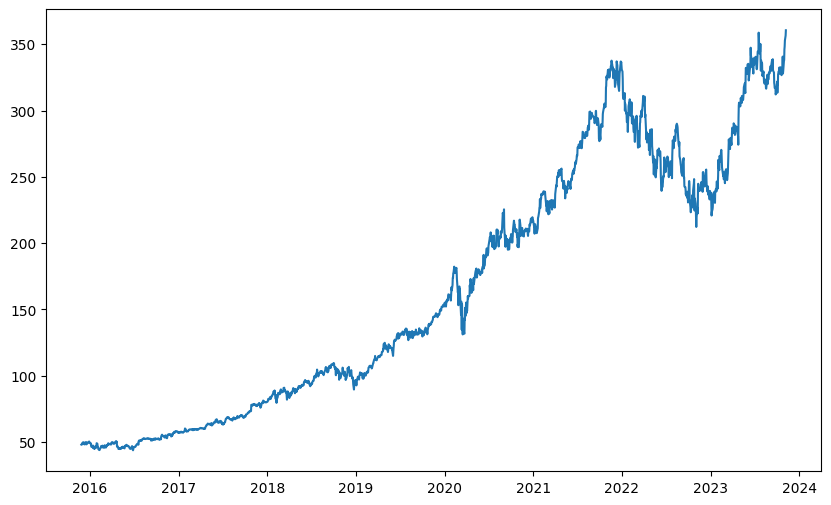

In [23]:
plt.figure(figsize=(10,6))
plt.plot(windowed_df.index, windowed_df["Price"])

In [24]:
from sklearn.preprocessing import MinMaxScaler

min_max = (df["Price"].min(), df["Price"].max())
scaler = MinMaxScaler(feature_range=(0, 1))

def split_normalize_dataframe(windowed_df):
  dates = windowed_df.index.to_numpy()

  df_scaled = scaler.fit_transform(windowed_df)

  X = df_scaled[:, :-1]
  Y = df_scaled[:, -1]

  return dates, X, Y

# Split dataframe into numpy arrays for the index Dates, input X and output Y
# and normalize price values to fit into [0, 1] range using min_max method
dates, X, Y = split_normalize_dataframe(windowed_df)

dates.shape, X.shape, Y.shape

((2000,), (2000, 7), (2000,))

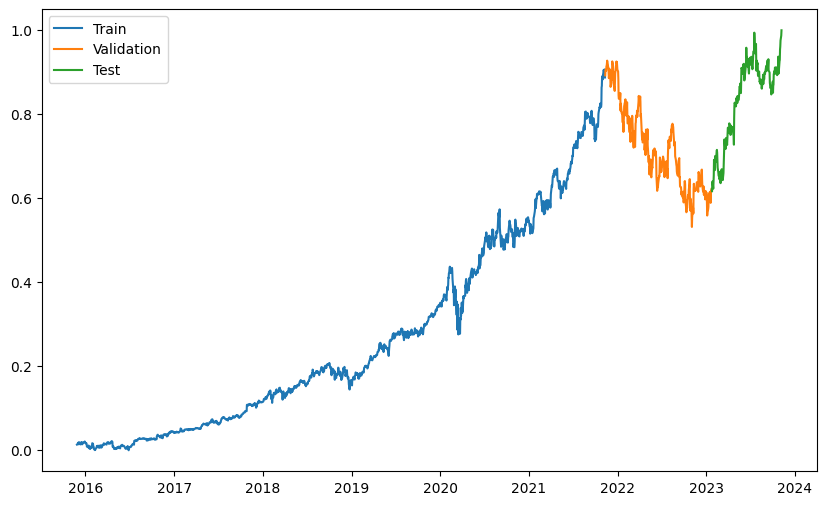

In [25]:
# Separate data into 75% training, 15% validation and 10% test
q75 = int(len(dates) * .75)
q90 = int(len(dates) * .9)

dates_train, X_train, Y_train = dates[:q75], X[:q75], Y[:q75]
dates_val, X_val, Y_val = dates[q75:q90], X[q75:q90], Y[q75:q90]
dates_test, X_test, Y_test = dates[q90:], X[q90:], Y[q90:]

plt.figure(figsize=(10,6))
plt.plot(dates_train, Y_train)
plt.plot(dates_val, Y_val)
plt.plot(dates_test, Y_test)
plt.legend(["Train", "Validation", "Test"])

## Model Training

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, backend

# Maybe adjust hyper parameters

model = Sequential([
    layers.Input((lookback, 1)),
    layers.LSTM(128, return_sequences=True),
    layers.LSTM(128, return_sequences=False),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.01), # avoid overfitting
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

model.compile(
    loss="mean_squared_error",
    optimizer=Adam(learning_rate=0.0001),
    metrics=["mean_absolute_error"] # extra metrics
  )

model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=30)

Epoch 1/30
47/47 [==============================] - 8s 85ms/step - loss: 0.0787 - mean_absolute_error: 0.1993 - val_loss: 0.1151 - val_mean_absolute_error: 0.3336
Epoch 2/30
47/47 [==============================] - 3s 62ms/step - loss: 0.0076 - mean_absolute_error: 0.0716 - val_loss: 0.0022 - val_mean_absolute_error: 0.0391
Epoch 3/30
47/47 [==============================] - 2s 53ms/step - loss: 8.5467e-04 - mean_absolute_error: 0.0230 - val_loss: 0.0026 - val_mean_absolute_error: 0.0409
Epoch 4/30
47/47 [==============================] - 3s 55ms/step - loss: 4.2473e-04 - mean_absolute_error: 0.0135 - val_loss: 0.0014 - val_mean_absolute_error: 0.0309
Epoch 5/30
47/47 [==============================] - 3s 57ms/step - loss: 3.2608e-04 - mean_absolute_error: 0.0116 - val_loss: 0.0015 - val_mean_absolute_error: 0.0318
Epoch 6/30
47/47 [==============================] - 4s 86ms/step - loss: 2.7005e-04 - mean_absolute_error: 0.0100 - val_loss: 0.0011 - val_mean_absolute_error: 0.0279
Epoch 

## Results

In [27]:
def denormalize(val):
  mn, mx = min_max
  return val * (mx - mn) + mn

47/47 [==============================] - 1s 9ms/step


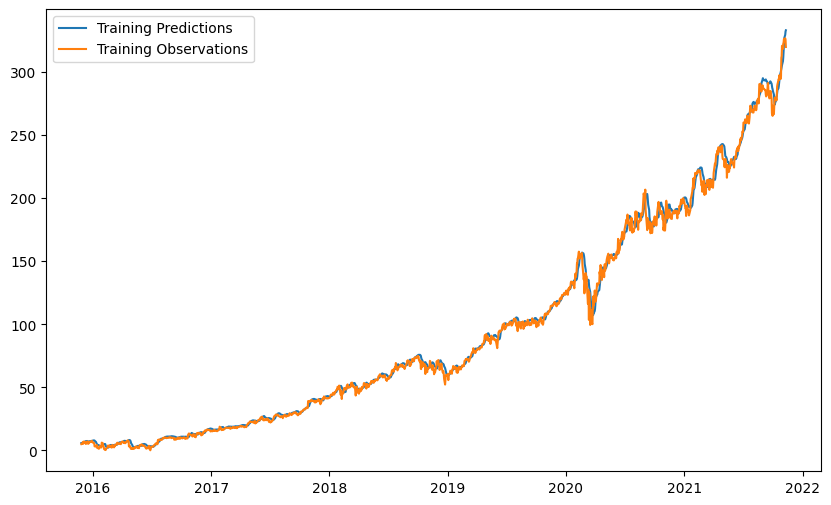

In [28]:
train_predictions = model.predict(X_train)

train_predictions = pd.DataFrame(train_predictions).apply(denormalize)
Y_train = pd.DataFrame(Y_train).apply(denormalize)

plt.figure(figsize=(10,6))
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, Y_train)
plt.legend(["Training Predictions", "Training Observations"])

10/10 [==============================] - 0s 10ms/step


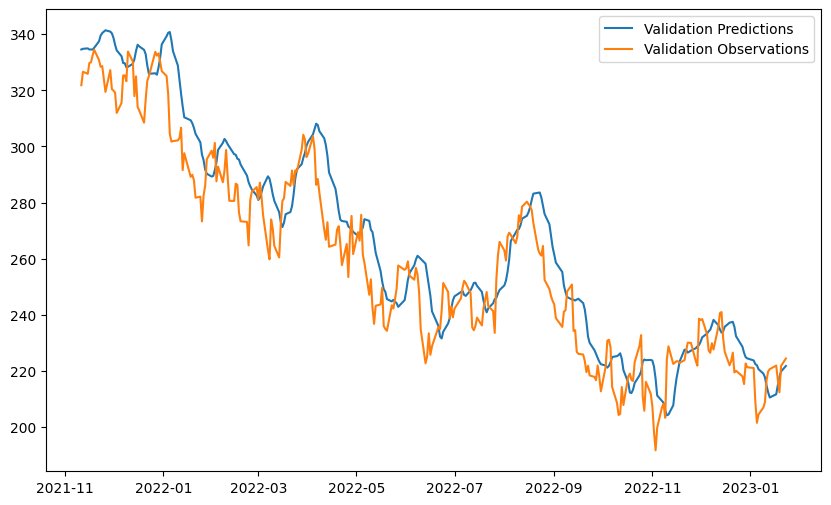

In [29]:
val_predictions = model.predict(X_val).flatten()

val_predictions = pd.DataFrame(val_predictions).apply(denormalize)
Y_val = pd.DataFrame(Y_val).apply(denormalize)

plt.figure(figsize=(10,6))
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, Y_val)
plt.legend(["Validation Predictions", "Validation Observations"])

7/7 [==============================] - 0s 12ms/step


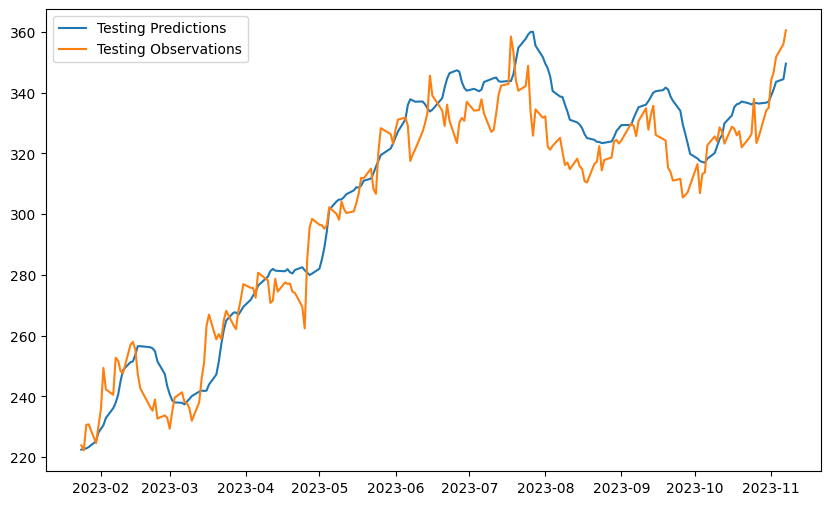

In [30]:
test_predictions = model.predict(X_test).flatten()

test_predictions = pd.DataFrame(test_predictions).apply(denormalize)
Y_test = pd.DataFrame(Y_test).apply(denormalize)

plt.figure(figsize=(10,6))
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, Y_test)
plt.legend(["Testing Predictions", "Testing Observations"])

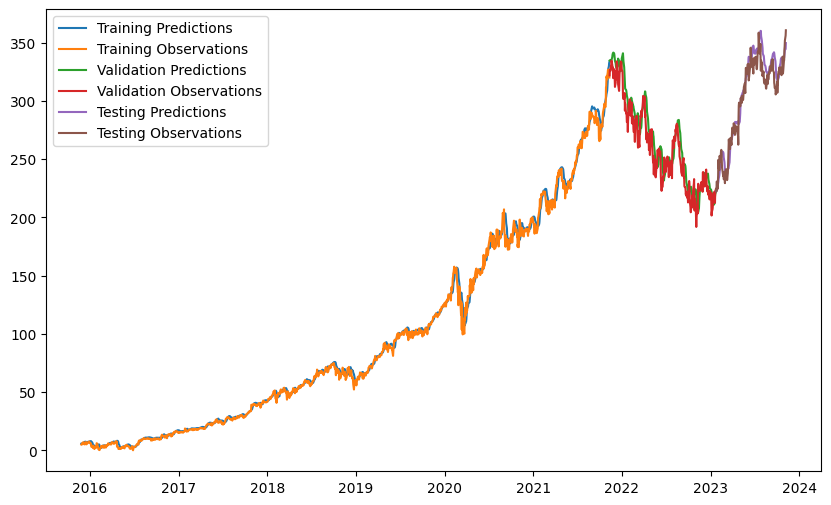

In [31]:
plt.figure(figsize=(10,6))
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, Y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, Y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, Y_test)

plt.legend([
    "Training Predictions",
    "Training Observations",
    "Validation Predictions",
    "Validation Observations",
    "Testing Predictions",
    "Testing Observations"
])

In [32]:
from copy import deepcopy
import numpy as np

# Generate all the values for the test dates
# using only values generated by the model itself
# result not very
recursive_predictions = []
recursive_dates = dates_test

last_window = list(deepcopy(X_val[-1]))

for date in recursive_dates:
  next_prediction = model.predict(np.array([last_window])).flatten()
  last_window.pop(0)
  last_window.append(next_prediction[0])
  recursive_predictions.append(next_prediction[0])

recursive_predictions = pd.DataFrame(recursive_predictions).apply(denormalize)

1/1 [==============================] - 0s 25ms/step


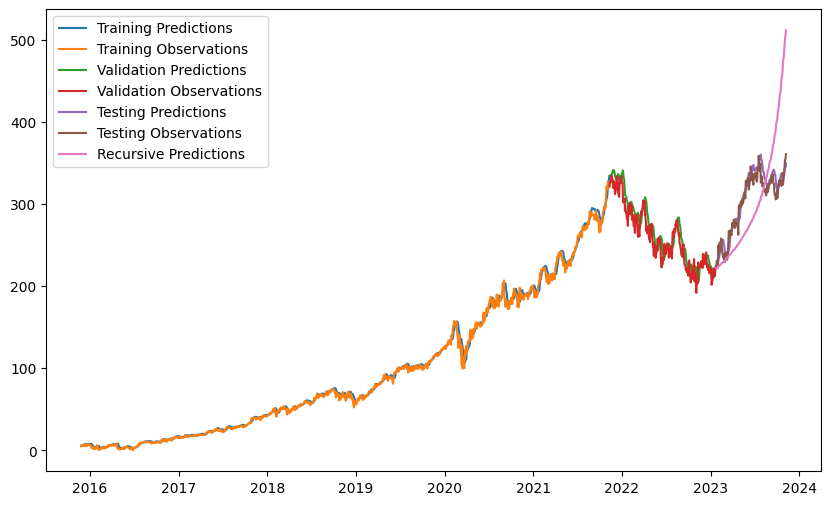

In [33]:
plt.figure(figsize=(10,6))
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, Y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, Y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, Y_test)
plt.plot(recursive_dates, recursive_predictions)

plt.legend([
    "Training Predictions",
    "Training Observations",
    "Validation Predictions",
    "Validation Observations",
    "Testing Predictions",
    "Testing Observations",
    "Recursive Predictions"
])

## Evaluation Metrics:

In [34]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

print("For the Testing Prediction curve")
print("Mean Absolute Error: ", mean_absolute_error(y_true=Y_test, y_pred=test_predictions))
print("Mean Square Error: ", mean_squared_error(y_true=Y_test, y_pred=test_predictions))
print()

print("For the Recursive Prediction curve:")
print("Mean Absolute Error: ", mean_absolute_error(y_true=Y_test, y_pred=recursive_predictions))
print("Mean Square Error: ", mean_squared_error(y_true=Y_test, y_pred=recursive_predictions))

For the Testing Prediction curve
Mean Absolute Error:  9.008257629316931
Mean Square Error:  128.45079681555546

For the Recursive Prediction curve:
Mean Absolute Error:  44.424165476638606
Mean Square Error:  3306.362670436079


## Using the same model for another market

Checking model's generalization capabilities

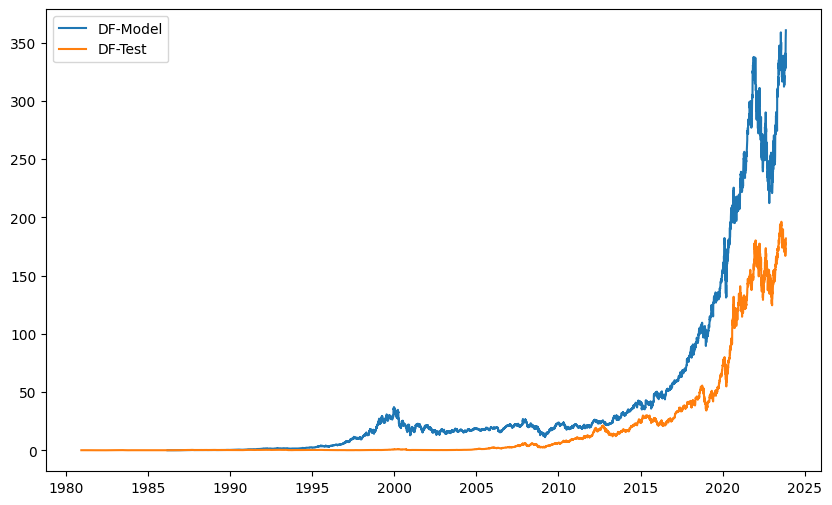

In [35]:
# Test Dataset
df2 = load_df("AAPL.csv")

plt.figure(figsize=(10,6))
plt.plot(df.index, df["Price"])
plt.plot(df2.index, df2["Price"])
plt.legend(["DF-Model", "DF-Test"])

63/63 [==============================] - 1s 10ms/step


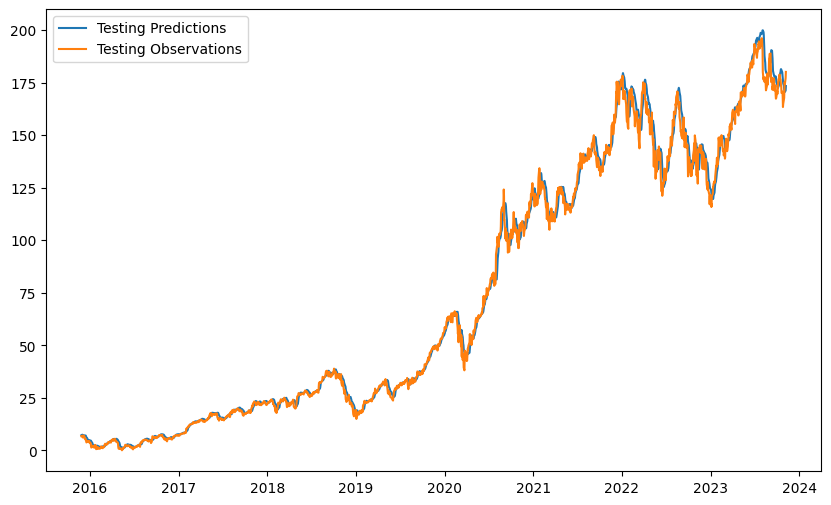

In [36]:
windowed_df2 = df_to_windowed(df2)
windowed_df2 = windowed_df2[-days:]

mn2, mx2 = (df2["Price"].min(), df2["Price"].max())

dates2, X2, Y2 = split_normalize_dataframe(windowed_df2)

Y2_pred = model.predict(X2)

Y2_pred = pd.DataFrame(Y2_pred).apply(lambda val : val * (mx2 - mn2) + mn2)
Y2 = pd.DataFrame(Y2).apply(lambda val : val * (mx2 - mn2) + mn2)

plt.figure(figsize=(10,6))
plt.plot(dates2, Y2_pred)
plt.plot(dates2, Y2)

plt.legend([
    "Testing Predictions",
    "Testing Observations"
])

In [37]:
print("Mean Absolute Error: ", mean_absolute_error(y_true=Y2, y_pred=Y2_pred))
print("Mean Square Error: ", mean_squared_error(y_true=Y2, y_pred=Y2_pred))

Mean Absolute Error:  2.6570197045745894
Mean Square Error:  17.268447629117787
